In [87]:
!pwd

/Users/kate/Documents/GitHub/NBM_EDA_Student/resources/get_mta


In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
week_nums = [211002,211009,211016,211023,211030,211106,211113,211120,211127,211204,211211,211218,211225]
dfs = []
for week_num in week_nums:
  dfs.append(pd.read_csv(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week_num}.txt"))
df = pd.concat(dfs)

In [3]:
from sqlalchemy import create_engine
from sqlalchemy import inspect

In [4]:
engine = create_engine("sqlite:///mta_data.db", pool_pre_ping=True)

In [5]:
!pwd

/Users/kate/Documents/GitHub/NBM_EDA_Student/resources/get_mta


In [6]:
insp = inspect(engine)
print(insp.get_table_names())

['mta_data']


In [53]:
df = pd.read_sql('SELECT * FROM mta_data;', engine)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


In [63]:
df_sql = pd.read_sql('SELECT STATION, (ENTRIES + EXITS), RANK() OVER(PARTITION BY STATION) AS NET_TRAFFIC FROM mta_data ORDER BY NET_TRAFFIC DESC', engine)
df_outliers = pd.read_sql('SELECT * FROM mta_data WHERE ENTRIES > 100000 OR EXITS > 100000 GROUP BY STATION', engine)

In [65]:
df_outliers.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,H007,R248,00-00-00,1 AV,L,BMT,12/18/2021,03:00:00,REGULAR,15688621,18317920
1,N037,R314,00-00-00,103 ST,BC,IND,12/18/2021,00:00:00,REGULAR,15158975,12052560
2,R529,R208,00-00-00,103 ST-CORONA,7,IRT,12/18/2021,03:00:00,REGULAR,16679750,26592136
3,J034,R007,00-00-00,104 ST,JZ,BMT,12/18/2021,03:00:00,REGULAR,295389,244209
4,R253,R181,00-00-00,110 ST,6,IRT,12/18/2021,03:00:00,REGULAR,5231688,8609050


In [8]:
df.DATE.nunique()


91

In [9]:
#rename columns
df.columns = ['control_area', 'unit','scp', 'station','lines','division','date','time','regular','entries','exits']


In [51]:
#take difference between entries/exits from one four-hour period to the next
df['net_entries'] = df.entries.diff()
df['net_exits'] = df.exits.diff()
df['net_traffic'] = df.entries.diff() + df.exits.diff()

#make datetime one column
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

#combine control area, unit, scp into one column for each turnstile
df.insert(0, 'turnstile', df.control_area + str(' ') + df.unit + str(' ') + df.scp)

#add days of week
import datetime
from datetime import datetime
df['day_of_week'] = df['datetime'].dt.day_name()

#delete unnecessary columns
df.drop(['control_area','unit','scp','lines','division','entries','exits'], axis=1, inplace = True)

AttributeError: 'DataFrame' object has no attribute 'entries'

In [11]:
#sort by datetime
df.sort_values(by = ['turnstile', 'datetime'])
df[500:510]

,turnstile,station,date,time,regular,net_entries,net_exits,net_traffic,datetime,day_of_week
500,A002 R051 02-06-00,59 ST,12/24/2021,11:00:00,REGULAR,37.0,10.0,47.0,2021-12-24 11:00:00,Friday
501,A002 R051 02-06-00,59 ST,12/24/2021,15:00:00,REGULAR,79.0,10.0,89.0,2021-12-24 15:00:00,Friday
502,A002 R051 02-06-00,59 ST,12/24/2021,19:00:00,REGULAR,159.0,22.0,181.0,2021-12-24 19:00:00,Friday
503,A002 R051 02-06-00,59 ST,12/24/2021,23:00:00,REGULAR,63.0,7.0,70.0,2021-12-24 23:00:00,Friday
504,A006 R079 00-00-00,5 AV/59 ST,12/18/2021,01:00:00,REGULAR,4335499.0,7916600.0,12252099.0,2021-12-18 01:00:00,Saturday
505,A006 R079 00-00-00,5 AV/59 ST,12/18/2021,05:00:00,REGULAR,15.0,11.0,26.0,2021-12-18 05:00:00,Saturday
506,A006 R079 00-00-00,5 AV/59 ST,12/18/2021,09:00:00,REGULAR,13.0,139.0,152.0,2021-12-18 09:00:00,Saturday
507,A006 R079 00-00-00,5 AV/59 ST,12/18/2021,13:00:00,REGULAR,49.0,284.0,333.0,2021-12-18 13:00:00,Saturday
508,A006 R079 00-00-00,5 AV/59 ST,12/18/2021,17:00:00,REGULAR,155.0,322.0,477.0,2021-12-18 17:00:00,Saturday
509,A006 R079 00-00-00,5 AV/59 ST,12/18/2021,21:00:00,REGULAR,208.0,155.0,363.0,2021-12-18 21:00:00,Saturday


In [12]:
#change all negative values to positive
df = df[df.net_traffic >= 0]
df = df[df.turnstile == df.shift(1).turnstile].reset_index(drop = True)
df[500:510]

,turnstile,station,date,time,regular,net_entries,net_exits,net_traffic,datetime,day_of_week
500,A006 R079 00-00-00,5 AV/59 ST,12/21/2021,01:00:00,REGULAR,108.0,37.0,145.0,2021-12-21 01:00:00,Tuesday
501,A006 R079 00-00-00,5 AV/59 ST,12/21/2021,05:00:00,REGULAR,13.0,0.0,13.0,2021-12-21 05:00:00,Tuesday
502,A006 R079 00-00-00,5 AV/59 ST,12/21/2021,09:00:00,REGULAR,21.0,387.0,408.0,2021-12-21 09:00:00,Tuesday
503,A006 R079 00-00-00,5 AV/59 ST,12/21/2021,13:00:00,REGULAR,60.0,608.0,668.0,2021-12-21 13:00:00,Tuesday
504,A006 R079 00-00-00,5 AV/59 ST,12/21/2021,17:00:00,REGULAR,253.0,404.0,657.0,2021-12-21 17:00:00,Tuesday
505,A006 R079 00-00-00,5 AV/59 ST,12/21/2021,21:00:00,REGULAR,311.0,185.0,496.0,2021-12-21 21:00:00,Tuesday
506,A006 R079 00-00-00,5 AV/59 ST,12/22/2021,01:00:00,REGULAR,124.0,44.0,168.0,2021-12-22 01:00:00,Wednesday
507,A006 R079 00-00-00,5 AV/59 ST,12/22/2021,05:00:00,REGULAR,12.0,5.0,17.0,2021-12-22 05:00:00,Wednesday
508,A006 R079 00-00-00,5 AV/59 ST,12/22/2021,09:00:00,REGULAR,25.0,320.0,345.0,2021-12-22 09:00:00,Wednesday
509,A006 R079 00-00-00,5 AV/59 ST,12/22/2021,13:00:00,REGULAR,80.0,470.0,550.0,2021-12-22 13:00:00,Wednesday


In [13]:
df['net_traffic'].describe()

count    2.611147e+06
mean     7.256129e+03
std      4.071591e+06
min      0.000000e+00
25%      1.800000e+01
50%      8.900000e+01
75%      2.330000e+02
max      3.559561e+09
Name: net_traffic, dtype: float64

In [14]:
#get rid of unreasonably large values by assigning df1 to be our original df sorted by total traffic. Indices up to 135 are unreasonably large, so only those after 135 are included.
df1 = df.sort_values(by = 'net_traffic', ascending = False)[135:]

In [15]:
#Confirm that new df has minimum = 0 and maximum = approximately 3,000
df1['net_traffic'].describe()

count    2.611012e+06
mean     1.627877e+02
std      2.041782e+02
min      0.000000e+00
25%      1.800000e+01
50%      8.900000e+01
75%      2.330000e+02
max      2.961000e+03
Name: net_traffic, dtype: float64

In [16]:
df1.columns

Index(['turnstile', 'station', 'date', 'time', 'regular', 'net_entries',
       'net_exits', 'net_traffic', 'datetime', 'day_of_week'],
      dtype='object')

In [50]:
#df3 is one row per datetime unit, 4 hour intervals. Each row = all turnstiles for one station in 4-hour window.
df3 = df1.groupby(['station','datetime', 'day_of_week'], as_index = False)['net_traffic'].sum().reset_index()
df3 = df3.sort_values('net_traffic', ascending = False)
df3.head(10)

,index,station,datetime,day_of_week,net_traffic
43256,43256,34 ST-PENN STA,2021-11-23 19:00:00,Tuesday,42701.0
41804,41804,34 ST-HERALD SQ,2021-11-24 19:00:00,Wednesday,42081.0
41898,41898,34 ST-HERALD SQ,2021-12-10 19:00:00,Friday,41417.0
41798,41798,34 ST-HERALD SQ,2021-11-23 19:00:00,Tuesday,40842.0
41857,41857,34 ST-HERALD SQ,2021-12-03 19:00:00,Friday,40457.0
41892,41892,34 ST-HERALD SQ,2021-12-09 19:00:00,Thursday,40428.0
41880,41880,34 ST-HERALD SQ,2021-12-07 19:00:00,Tuesday,40140.0
41886,41886,34 ST-HERALD SQ,2021-12-08 19:00:00,Wednesday,40118.0
41939,41939,34 ST-HERALD SQ,2021-12-17 19:00:00,Friday,40009.0
41921,41921,34 ST-HERALD SQ,2021-12-14 19:00:00,Tuesday,39978.0


In [75]:
#assign penn_34th as the data frame for 34th Street and Penn Station, because it is the station with the most total traffic
penn_34th = df1[df1.station == '34 ST-PENN STA'].groupby(['station','date','time','datetime','day_of_week'], as_index = False)['net_traffic'].sum().reset_index()
#penn_34th = penn_34th.sort_values('net_traffic', ascending = False)
penn_34th.head(10)

,index,station,date,time,datetime,day_of_week,net_traffic
0,0,34 ST-PENN STA,09/25/2021,04:00:00,2021-09-25 04:00:00,Saturday,1113.0
1,1,34 ST-PENN STA,09/25/2021,06:00:00,2021-09-25 06:00:00,Saturday,332.0
2,2,34 ST-PENN STA,09/25/2021,08:00:00,2021-09-25 08:00:00,Saturday,3326.0
3,3,34 ST-PENN STA,09/25/2021,10:00:00,2021-09-25 10:00:00,Saturday,3274.0
4,4,34 ST-PENN STA,09/25/2021,12:00:00,2021-09-25 12:00:00,Saturday,10439.0
5,5,34 ST-PENN STA,09/25/2021,14:00:00,2021-09-25 14:00:00,Saturday,6109.0
6,6,34 ST-PENN STA,09/25/2021,16:00:00,2021-09-25 16:00:00,Saturday,17002.0
7,7,34 ST-PENN STA,09/25/2021,18:00:00,2021-09-25 18:00:00,Saturday,7235.0
8,8,34 ST-PENN STA,09/25/2021,20:00:00,2021-09-25 20:00:00,Saturday,16300.0
9,9,34 ST-PENN STA,09/25/2021,22:00:00,2021-09-25 22:00:00,Saturday,5331.0


In [ ]:
penn_34th.groupby([''])

In [74]:
#penn_34th['time'].unique()
penn_34th.groupby(['time'], as_index = False)['net_traffic'].sum().reset_index().tail(60)

,index,time,net_traffic
19,19,08:36:54,12.0
20,20,08:38:15,4.0
21,21,08:39:35,23.0
22,22,08:41:04,11.0
23,23,08:58:53,963.0
24,24,09:00:00,346639.0
25,25,09:00:14,25.0
26,26,09:01:34,20.0
27,27,09:02:54,23.0
28,28,09:04:14,4.0


In [23]:
df1.groupby(['station'], as_index = True)['net_traffic'].sum().reset_index()

,station,net_traffic
0,1 AV,2223472.0
1,103 ST,2431611.0
2,103 ST-CORONA,2068937.0
3,104 ST,297752.0
4,110 ST,1011764.0
...,...,...
374,WOODLAWN,404119.0
375,WORLD TRADE CTR,1036001.0
376,WTC-CORTLANDT,818063.0
377,YORK ST,778163.0


In [24]:
#df_stations is our data frame grouped by station. One row per station.
df_stations = pd.DataFrame(df1.groupby('station')['net_traffic'].sum()).reset_index()
df_stations.sort_values(by = 'net_traffic', ascending = False, inplace = True)
df_stations.head()

,station,net_traffic
61,34 ST-PENN STA,11438522.0
233,GRD CNTRL-42 ST,8607911.0
59,34 ST-HERALD SQ,8465231.0
14,14 ST-UNION SQ,7734528.0
110,86 ST,7685949.0


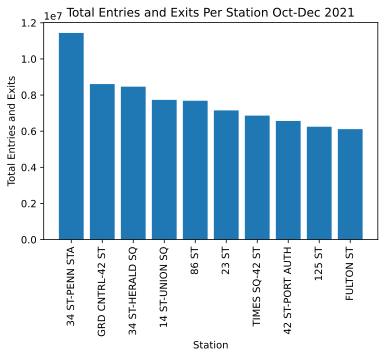

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina, enables diff formats, if multiple, uses best
%matplotlib inline

plt.bar(x=df_stations['station'][:10], height=df_stations['net_traffic'][:10]) #height is y
plt.xticks(rotation=90);
plt.ylabel("Total Entries and Exits");
plt.xlabel("Station");
plt.title('Total Entries and Exits Per Station Oct-Dec 2021');

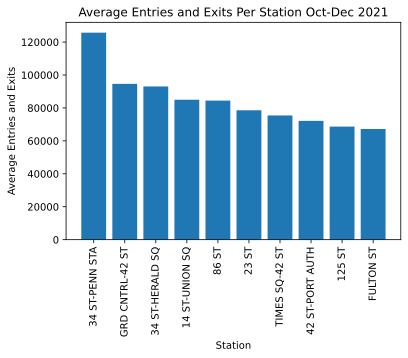

In [26]:
plt.bar(x=df_stations['station'][:10], height=(df_stations['net_traffic'] / 91)[:10])
plt.xticks(rotation=90);
plt.ylabel("Average Entries and Exits");
plt.xlabel("Station");
plt.title('Average Entries and Exits Per Station Oct-Dec 2021');

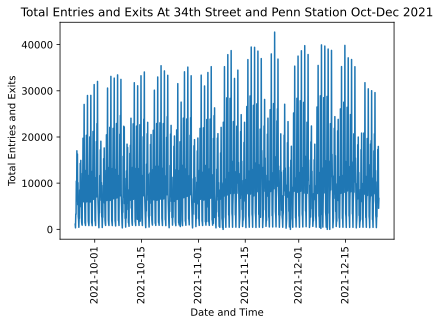

In [29]:
plt.plot(penn_34th['datetime'],penn_34th['net_traffic'])
plt.xticks(rotation=90);
plt.ylabel("Total Entries and Exits");
plt.xlabel("Date and Time");
plt.title('Total Entries and Exits At 34th Street and Penn Station Oct-Dec 2021');

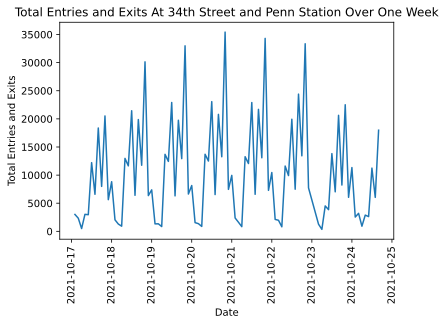

In [31]:
plt.plot(penn_34th['datetime'][260:350],penn_34th['net_traffic'][260:350])
plt.xticks(rotation=90);
plt.ylabel("Total Entries and Exits");
plt.xlabel("Date");
plt.title('Total Entries and Exits At 34th Street and Penn Station Over One Week');

In [84]:
import datetime
import pandas as pd
from datetime import datetime 
plt.plot(pd.DataFrame(penn_34th['datetime']).datetime.time(),penn_34th['net_traffic'])
#plt.axes()
plt.xticks(rotation=90);
#plt.xticks(np.arange(0, 23, 1))
plt.ylabel("Total Entries and Exits");
plt.xlabel("Time");
plt.title('Total Entries and Exits At 34th Street and Penn Station by Time of Day');

AttributeError: 'Series' object has no attribute 'time'

In [86]:
import plotly.express as px
fig = px.scatter(penn_34th, x="datetime", y="net_traffic", color="day_of_week")
fig.show()